In [ ]:
# Distance-based methods

В данном ноутбуке реализуются distance-based подходы к атрибуции авторства,
основанные на векторных представлениях текстов и мерах сходства.

Рассматриваются:
- TF-IDF представления различной размерности
- косинусное сходство
- min–max (Tanimoto) сходство
- марджины уверенности
- стабильность предсказаний


In [5]:
import pandas as pd

# пути к файлам
train_path = "/Users/anastasiabogdanova/R_directory/iskra-project/ml-mini-project/data/train_chunks.csv"
dubia_path = "/Users/anastasiabogdanova/R_directory/iskra-project/ml-mini-project/data/dubia_clean.csv"

# загружаем CSV
df_train = pd.read_csv(train_path)
df_dubia = pd.read_csv(dubia_path, usecols=["author", "filename", "text"]) # только нужные столбцы

print(f"Train chunks: {len(df_train)}")
print(f"Dubia: {len(df_dubia)}")

# проверка первых строк
df_train.head(3), df_dubia.head(3)


Train chunks: 574
Dubia: 7


(  author                              filename  \
 0  lenin  lenin_les_beaux_esprits_I.txt_chunk1   
 1  lenin  lenin_les_beaux_esprits_I.txt_chunk2   
 2  lenin  lenin_padenie_port_artura.txt_chunk1   
 
                                                 text  
 0  LES BEAUX ESPRITS SE RENCONTRENT Знаменитая аг...  
 1  с другой стороны, надо признаться, что Давид, ...  
 2  Падение Порт-Артура “Порт-Артур капитулировал....  ,
   author                          filename  \
 0  dubia  dubia_poslednee_slovo_bund_I.txt   
 1  dubia  dubia_priznaki_bankrotstva_I.txt   
 2  dubia        dubia_novoe_poboishe_I.txt   
 
                                                 text  
 0  последнее слово бундовского национализма загра...  
 1  признаки банкротства всего только год прошел с...  
 2  новое побоище повидимому мы переживаем момент ...  )

In [ ]:
## TF-IDF vectorization

Для представления текстов используются TF-IDF векторы с различным числом признаков (300, 500, 1000)

Сравнение размерностей позволяет оценить устойчивость результатов к изменению параметров векторизации.


In [17]:
import re

# кастомные стоп-слова: римские числа и отдельные специфические символы
custom_stopwords = [
    'i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x',
    'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xvii', 'xviii', 'xix', 'xx'
]

def clean_tokenizer(text):
    # находим все токены (слова)
    tokens = re.findall(r'\b\w+\b', text.lower())
    
    # фильтруем токены
    tokens = [
        t for t in tokens
        if re.search('[а-яё]', t)      # хотя бы одна русская буква
        and t not in custom_stopwords  # исключаем кастомные стоп-слова
        and not t.isdigit()            # исключаем любые числа
    ]
    
    return tokens

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# размеры TF-IDF
tfidf_sizes = [300, 500, 1000]

# словарь для хранения результатов
tfidf_results = {}

for size in tfidf_sizes:
    print(f"Векторизация TF-IDF с {size} признаками...")

    vectorizer = TfidfVectorizer(
        tokenizer=clean_tokenizer,  # твой кастомный токенизатор
        lowercase=True,
        max_features=size
    )

    # обучаем на train
    X_train = vectorizer.fit_transform(df_train["text"])
    
    # преобразуем dubia по той же векторизации
    X_dubia = vectorizer.transform(df_dubia["text"])
    
    # сохраняем результаты в словарь
    tfidf_results[size] = {
        "vectorizer": vectorizer,
        "X_train": X_train,
        "X_dubia": X_dubia
    }


Векторизация TF-IDF с 300 признаками...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Векторизация TF-IDF с 500 признаками...
Векторизация TF-IDF с 1000 признаками...


In [82]:
X_train = tfidf_results[500]["X_train"] 
X_dubia = tfidf_results[500]["X_dubia"]
print(X_train.shape, X_dubia.shape)


(574, 500) (7, 500)


In [84]:
# Для каждого размера TF-IDF распечатаем первые 10 признаков

for size in [300, 500, 1000]:
    vectorizer = tfidf_results[size]["vectorizer"]
    feature_names = vectorizer.get_feature_names_out()
    print(f"Первые 10 признаков для TF-IDF {size}: {feature_names[:10]}")


Первые 10 признаков для TF-IDF 300: ['а' 'без' 'более' 'больше' 'борьба' 'борьбе' 'борьбу' 'борьбы' 'будет'
 'будто']
Первые 10 признаков для TF-IDF 500: ['а' 'армии' 'б' 'без' 'более' 'больше' 'большинства' 'большинство'
 'борьба' 'борьбе']
Первые 10 признаков для TF-IDF 1000: ['а' 'автор' 'агитации' 'аксельрод' 'армии' 'б' 'без' 'безусловно'
 'благодаря' 'более']


In [ ]:
## 3. Cosine similarity (text-to-text)

Вычисляется косинусное сходство со всеми текстами каждого автора обучающего корпуса.
Применяется к dubia-текстам.


In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# словарь для хранения результатов по размерам TF-IDF
cosine_results = {}

# авторы в train
authors = df_train["author"].unique()

for size in tfidf_sizes:  # [300, 500, 1000]
    print(f"\nВычисляем cosine similarity для TF-IDF с {size} признаками...")
    
    X_train = tfidf_results[size]["X_train"]
    X_dubia = tfidf_results[size]["X_dubia"]
    
    # --- Проверка на train-текстах ---
    train_check = []
    for i, row in df_train.iterrows():
        text_vec = X_train[i]
        sims = {}
        for author in authors:
            idx = df_train["author"] == author
            author_vecs = X_train[idx]
            sims[author] = cosine_similarity(text_vec, author_vecs).flatten().max()
        predicted = max(sims, key=sims.get)
        train_check.append({
            "filename": row["filename"],
            "true_author": row["author"],
            f"predicted_author_{size}": predicted,
            **sims
        })
    df_train_check = pd.DataFrame(train_check)
    print(f"Первые 5 проверок на train (TF-IDF {size}):")
    print(df_train_check.head())

    # --- Применяем к dubia ---
    dubia_pred = []
    for i, row in df_dubia.iterrows():
        text_vec = X_dubia[i]
        sims = {}
        for author in authors:
            idx = df_train["author"] == author
            author_vecs = X_train[idx]
            sims[author] = cosine_similarity(text_vec, author_vecs).flatten().max()
        predicted = max(sims, key=sims.get)
        dubia_pred.append({
            "filename": row["filename"],
            f"predicted_author_{size}": predicted,
            **sims
        })
    df_dubia_pred = pd.DataFrame(dubia_pred)
    
    # сохраняем результаты для текущего размера
    cosine_results[size] = {
        "train_check": df_train_check,
        "dubia_pred": df_dubia_pred
    }




Вычисляем cosine similarity для TF-IDF с 300 признаками...
Первые 5 проверок на train (TF-IDF 300):
                               filename true_author predicted_author_300  \
0  lenin_les_beaux_esprits_I.txt_chunk1       lenin                lenin   
1  lenin_les_beaux_esprits_I.txt_chunk2       lenin                lenin   
2  lenin_padenie_port_artura.txt_chunk1       lenin                lenin   
3  lenin_padenie_port_artura.txt_chunk2       lenin                lenin   
4  lenin_padenie_port_artura.txt_chunk3       lenin                lenin   

   lenin    martov    parvus  plehanov   trotsky  
0    1.0  0.829193  0.760775  0.775196  0.869203  
1    1.0  0.330239  0.323388  0.322222  0.397223  
2    1.0  0.754439  0.724637  0.694610  0.732018  
3    1.0  0.770327  0.756862  0.709701  0.801851  
4    1.0  0.559664  0.608923  0.584975  0.652090  

Вычисляем cosine similarity для TF-IDF с 500 признаками...
Первые 5 проверок на train (TF-IDF 500):
                               file

In [33]:
for size in tfidf_sizes:
    df_check = cosine_results[size]["train_check"]
    correct = (df_check[f"predicted_author_{size}"] == df_check["true_author"]).sum()
    total = len(df_check)
    accuracy = correct / total
    print(f"TF-IDF {size} признаков: точность на train = {accuracy:.2%}")


TF-IDF 300 признаков: точность на train = 99.83%
TF-IDF 500 признаков: точность на train = 99.83%
TF-IDF 1000 признаков: точность на train = 99.83%


In [88]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# --- Словарь для хранения результатов ---
cosine_results = {}

# список авторов из train
authors = df_train['author'].unique()

for size in tfidf_sizes:
    print(f"Вычисляем cosine similarity для TF-IDF с {size} признаками на dubia...")
    
    X_train = tfidf_results[size]['X_train']
    X_dubia = tfidf_results[size]['X_dubia']
    
    results = []
    
    for i, row in df_dubia.iterrows():
        text_vector = X_dubia[i]
        similarities = {}
        
        for author in authors:
            idx = df_train['author'] == author
            author_vectors = X_train[idx]
            
            sims = cosine_similarity(text_vector, author_vectors).flatten()
            similarities[author] = sims.max()  # максимальное сходство с текстами автора
        
        # выбираем автора с максимальным сходством
        predicted_author = max(similarities, key=similarities.get)
        
        results.append({
            "filename": row["filename"],
            f"predicted_author_{size}": predicted_author,
            **similarities
        })
    
    cosine_results[size] = pd.DataFrame(results)

# --- пример вывода для TF-IDF 1000 ---
cosine_results[1000].head(10)



Вычисляем cosine similarity для TF-IDF с 300 признаками на dubia...
Вычисляем cosine similarity для TF-IDF с 500 признаками на dubia...
Вычисляем cosine similarity для TF-IDF с 1000 признаками на dubia...


,filename,predicted_author_1000,lenin,martov,parvus,plehanov,trotsky
0,dubia_poslednee_slovo_bund_I.txt,lenin,0.774928,0.385904,0.360682,0.743328,0.389901
1,dubia_priznaki_bankrotstva_I.txt,lenin,0.718818,0.689462,0.667923,0.672650,0.674032
2,dubia_novoe_poboishe_I.txt,lenin,0.683473,0.607822,0.596590,0.652917,0.671093
3,dubia_ot_red_iskry_I.txt,lenin,0.701465,0.659099,0.552830,0.606811,0.597652
4,dubia_slovo_mosc_vedomostyam_I.txt,lenin,0.684202,0.655146,0.621201,0.641336,0.678146
5,dubia_nasushnie_zadachi_I.txt,lenin,0.664251,0.657528,0.548060,0.604267,0.590361
6,dubia_zakon_o_voznagr_I.txt,trotsky,0.732794,0.652334,0.617305,0.685311,0.744195


In [ ]:
## Stability

Стабильность определяется как совпадение предсказанного автора
при использовании TF-IDF различных размерностей (300 / 500 / 1000).

In [37]:
import numpy as np
import pandas as pd

# --- Функция для расчёта margin ---
def compute_margin(df_scores, authors):
    margins = []
    for i, row in df_scores.iterrows():
        scores = row[authors].values
        sorted_scores = np.sort(scores)[::-1]  # по убыванию
        margin = sorted_scores[0] - sorted_scores[1]  # разница между лучшим и вторым
        margins.append(margin)
    return margins

# --- Собираем финальный DataFrame ---
df_final_cosine = cosine_results[300][['filename', 'predicted_author_300']].copy()

# Добавляем предсказания для остальных размеров
for size in [500, 1000]:
    df_final_cosine = df_final_cosine.merge(
        cosine_results[size][['filename', f'predicted_author_{size}']],
        on='filename'
    )

# Стабильность: True, если все предсказания совпадают
df_final_cosine['stable_cosine'] = df_final_cosine.apply(
    lambda row: len({row['predicted_author_300'],
                     row['predicted_author_500'],
                     row['predicted_author_1000']}) == 1,
    axis=1
)

# Список авторов
authors = df_train['author'].unique()

# Рассчитываем margin только для TF-IDF 1000
df_final_cosine['cosine_margin_1000'] = compute_margin(cosine_results[1000], authors)

# --- Вывод финальной таблицы ---
df_final_cosine.head()



,filename,predicted_author_300,predicted_author_500,predicted_author_1000,stable_cosine,cosine_margin_1000
0,dubia_poslednee_slovo_bund_I.txt,lenin,plehanov,lenin,False,0.031601
1,dubia_priznaki_bankrotstva_I.txt,martov,lenin,lenin,False,0.029356
2,dubia_novoe_poboishe_I.txt,trotsky,trotsky,lenin,False,0.012380
3,dubia_ot_red_iskry_I.txt,lenin,lenin,lenin,True,0.042366
4,dubia_slovo_mosc_vedomostyam_I.txt,lenin,lenin,lenin,True,0.006055


In [ ]:
## 4. Tanimoto (min–max) similarity

В качестве альтернативной меры сходства используется Tanimoto (min-max) similarity, применяемая к TF-IDF векторам.
Для каждого dubia-текста вычисляется максимальное сходство с текстами каждого автора.


In [41]:
# Проверяем точность Tanimoto на train

# --- Функция min-max Tanimoto ---
def minmax_tanimoto(vec1, vec2):
    numerator = np.minimum(vec1, vec2).sum()
    denominator = np.maximum(vec1, vec2).sum()
    return numerator / denominator if denominator != 0 else 0.0


from sklearn.model_selection import train_test_split

# переводим разреженные матрицы в dense
X_train_dense = tfidf_results[1000]['X_train'].toarray()
authors = df_train['author'].unique()

correct = 0
for i, row in df_train.iterrows():
    text_vector = X_train_dense[i]
    similarities = {}
    
    for author in authors:
        idx = (df_train['author'] == author) & (df_train.index != i)  # исключаем сам текст
        author_vectors = X_train_dense[idx]
        sims = [minmax_tanimoto(text_vector, vec) for vec in author_vectors]
        similarities[author] = max(sims)
    
    predicted_author = max(similarities, key=similarities.get)
    if predicted_author == row['author']:
        correct += 1

accuracy = correct / len(df_train)
print(f"Tanimoto accuracy on train: {accuracy:.2%}")



Tanimoto accuracy on train: 95.30%


In [43]:
# --- Рассчитываем Tanimoto для dubia ---
tfidf_sizes = [300, 500, 1000]
tanimoto_results = {}

authors = df_train['author'].unique()

for size in tfidf_sizes:
    print(f"Вычисляем Tanimoto для TF-IDF {size} признаков...")
    
    X_train = tfidf_results[size]['X_train'].toarray()  # перевод в dense для min-max
    X_dubia = tfidf_results[size]['X_dubia'].toarray()
    
    results = []
    for i, row in df_dubia.iterrows():
        text_vector = X_dubia[i]
        similarities = {}
        for author in authors:
            idx = df_train['author'] == author
            author_vectors = X_train[idx]
            sims = [minmax_tanimoto(text_vector, vec) for vec in author_vectors]
            similarities[author] = max(sims)
        
        predicted_author = max(similarities, key=similarities.get)
        results.append({
            "filename": row['filename'],
            f'predicted_author_tanimoto_{size}': predicted_author,
            **similarities
        })
    
    tanimoto_results[size] = pd.DataFrame(results)

tanimoto_results[1000]

Вычисляем Tanimoto для TF-IDF 300 признаков...
Вычисляем Tanimoto для TF-IDF 500 признаков...
Вычисляем Tanimoto для TF-IDF 1000 признаков...


,filename,predicted_author_tanimoto_1000,lenin,martov,parvus,plehanov,trotsky
0,dubia_poslednee_slovo_bund_I.txt,lenin,0.322699,0.184149,0.197958,0.257666,0.193145
1,dubia_priznaki_bankrotstva_I.txt,parvus,0.269345,0.266769,0.269940,0.263139,0.260213
2,dubia_novoe_poboishe_I.txt,lenin,0.269655,0.225715,0.255658,0.259448,0.258616
3,dubia_ot_red_iskry_I.txt,martov,0.279427,0.279768,0.222323,0.251717,0.236872
4,dubia_slovo_mosc_vedomostyam_I.txt,lenin,0.269770,0.265606,0.253381,0.255833,0.264841
5,dubia_nasushnie_zadachi_I.txt,lenin,0.287082,0.277823,0.219911,0.234719,0.228921
6,dubia_zakon_o_voznagr_I.txt,lenin,0.318274,0.247709,0.241689,0.263730,0.291648


In [47]:
# --- Собираем финальную таблицу для Tanimoto ---
df_final_tanimoto = tanimoto_results[300][['filename', 'predicted_author_tanimoto_300']].copy()
for size in [500, 1000]:
    df_final_tanimoto = df_final_tanimoto.merge(
        tanimoto_results[size][['filename', f'predicted_author_tanimoto_{size}']],
        on='filename'
    )

# Стабильность Tanimoto
df_final_tanimoto['stable_tanimoto'] = df_final_tanimoto.apply(
    lambda row: len({row['predicted_author_tanimoto_300'],
                     row['predicted_author_tanimoto_500'],
                     row['predicted_author_tanimoto_1000']}) == 1,
    axis=1
)

# Margin для TF-IDF 1000
df_final_tanimoto['tanimoto_margin_1000'] = compute_margin(tanimoto_results[1000], authors)

df_final_tanimoto

,filename,predicted_author_tanimoto_300,predicted_author_tanimoto_500,predicted_author_tanimoto_1000,stable_tanimoto,tanimoto_margin_1000
0,dubia_poslednee_slovo_bund_I.txt,lenin,lenin,lenin,True,0.065033
1,dubia_priznaki_bankrotstva_I.txt,martov,lenin,parvus,False,0.000595
2,dubia_novoe_poboishe_I.txt,lenin,lenin,lenin,True,0.010207
3,dubia_ot_red_iskry_I.txt,lenin,martov,martov,False,0.000341
4,dubia_slovo_mosc_vedomostyam_I.txt,lenin,lenin,lenin,True,0.004165
5,dubia_nasushnie_zadachi_I.txt,martov,martov,lenin,False,0.009259
6,dubia_zakon_o_voznagr_I.txt,lenin,lenin,lenin,True,0.026626


In [102]:
# --- Объединяем обе метрики в одну финальную таблицу ---
df_combined = df_final_cosine.merge(
    df_final_tanimoto,
    on='filename'
)


# --- Сохраняем объединённую таблицу ---
output_path = "/Users/anastasiabogdanova/R_directory/iskra-project/ml-mini-project/results/df_combined.csv"
df_combined.to_csv(output_path, index=False)
print(f"Объединённая таблица df_combined сохранена: {output_path}")

df_combined.head(10)


Объединённая таблица df_combined сохранена: /Users/anastasiabogdanova/R_directory/iskra-project/ml-mini-project/results/df_combined.csv


,filename,predicted_author_300,predicted_author_500,predicted_author_1000,stable_cosine,cosine_margin_1000,predicted_author_tanimoto_300,predicted_author_tanimoto_500,predicted_author_tanimoto_1000,stable_tanimoto,tanimoto_margin_1000
0,dubia_poslednee_slovo_bund_I.txt,lenin,plehanov,lenin,False,0.031601,lenin,lenin,lenin,True,0.065033
1,dubia_priznaki_bankrotstva_I.txt,martov,lenin,lenin,False,0.029356,martov,lenin,parvus,False,0.000595
2,dubia_novoe_poboishe_I.txt,trotsky,trotsky,lenin,False,0.012380,lenin,lenin,lenin,True,0.010207
3,dubia_ot_red_iskry_I.txt,lenin,lenin,lenin,True,0.042366,lenin,martov,martov,False,0.000341
4,dubia_slovo_mosc_vedomostyam_I.txt,lenin,lenin,lenin,True,0.006055,lenin,lenin,lenin,True,0.004165
5,dubia_nasushnie_zadachi_I.txt,martov,martov,lenin,False,0.006723,martov,martov,lenin,False,0.009259
6,dubia_zakon_o_voznagr_I.txt,trotsky,trotsky,trotsky,True,0.011401,lenin,lenin,lenin,True,0.026626


In [92]:
# Accuracy на train - проверим на разных размерностях

for size in tfidf_sizes:
    for metric in ['cosine', 'tanimoto']:
        X_train = tfidf_results[size]['X_train']
        y_true = df_train['author']
        
        # Считаем предсказания "на ближайшем соседе"
        from sklearn.metrics.pairwise import cosine_similarity
        sims = cosine_similarity(X_train, X_train)
        np.fill_diagonal(sims, -1)  # чтобы не совпадало с самим собой
        y_pred = [y_true[sims[i].argmax()] for i in range(len(y_true))]
        
        acc = (y_pred == y_true).mean()
        print(f"TF-IDF {size}, {metric} accuracy on train: {acc:.4f}")


TF-IDF 300, cosine accuracy on train: 0.8868
TF-IDF 300, tanimoto accuracy on train: 0.8868
TF-IDF 500, cosine accuracy on train: 0.8850
TF-IDF 500, tanimoto accuracy on train: 0.8850
TF-IDF 1000, cosine accuracy on train: 0.9024
TF-IDF 1000, tanimoto accuracy on train: 0.9024


In [65]:
#TF-IDF = 1000 признаков даёт максимальный accuracy, его и берём как основной для интерпретации Dubia

df_final = df_combined[[
    'filename',
    'predicted_author_1000',
    'predicted_author_tanimoto_1000',
    'cosine_margin_1000',
    'tanimoto_margin_1000',
    'stable_cosine',
    'stable_tanimoto'
]].copy()

df_final


,filename,predicted_author_1000,predicted_author_tanimoto_1000,cosine_margin_1000,tanimoto_margin_1000,stable_cosine,stable_tanimoto
0,dubia_poslednee_slovo_bund_I.txt,lenin,lenin,0.031601,0.065033,False,True
1,dubia_priznaki_bankrotstva_I.txt,lenin,parvus,0.029356,0.000595,False,False
2,dubia_novoe_poboishe_I.txt,lenin,lenin,0.012380,0.010207,False,True
3,dubia_ot_red_iskry_I.txt,lenin,martov,0.042366,0.000341,True,False
4,dubia_slovo_mosc_vedomostyam_I.txt,lenin,lenin,0.006055,0.004165,True,True
5,dubia_nasushnie_zadachi_I.txt,lenin,lenin,0.006723,0.009259,False,False
6,dubia_zakon_o_voznagr_I.txt,trotsky,lenin,0.011401,0.026626,True,True


In [ ]:
## Margin-based confidence

Для оценки уверенности предсказания использовался margin, определяемый как разница между:
- максимальным сходством
- вторым по величине сходством

Марджины рассчитывались отдельно для cosine similarity и Tanimoto similarity.


In [67]:
def margin_level(m):
    if m >= 0.05:
        return 'high'
    elif m >= 0.02:
        return 'medium'
    else:
        return 'low'

df_final['cosine_confidence'] = df_final['cosine_margin_1000'].apply(margin_level)
df_final['tanimoto_confidence'] = df_final['tanimoto_margin_1000'].apply(margin_level)


In [70]:
summary = pd.DataFrame({
    'metric': ['cosine', 'tanimoto'],
    'stable_texts': [
        df_final['stable_cosine'].sum(),
        df_final['stable_tanimoto'].sum()
    ],
    'high_confidence': [
        (df_final['cosine_confidence'] == 'high').sum(),
        (df_final['tanimoto_confidence'] == 'high').sum()
    ],
    'total_texts': [len(df_final), len(df_final)]
})

summary


,metric,stable_texts,high_confidence,total_texts
0,cosine,3,0,7
1,tanimoto,4,1,7


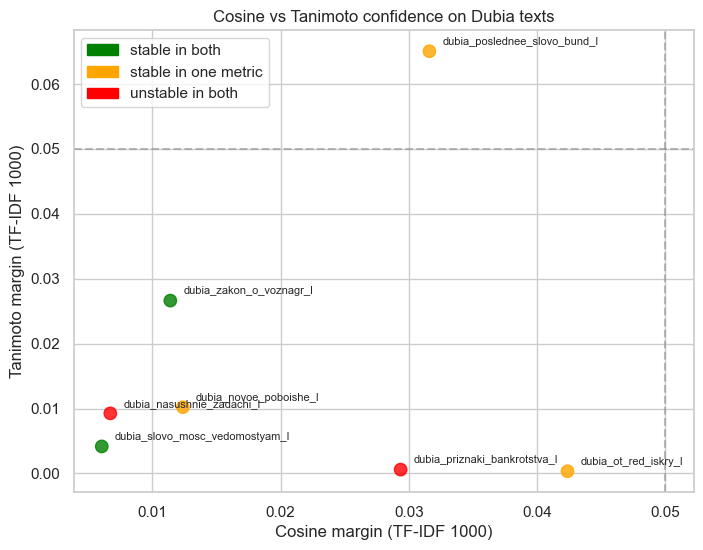

In [100]:
# Визуализируем stability & confidence & margin

import os
import matplotlib.pyplot as plt

df_plot = df_final.copy()

# цветовая маркировка по стабильности
def stability_color(row):
    if row['stable_cosine'] and row['stable_tanimoto']:
        return 'green'
    elif row['stable_cosine'] or row['stable_tanimoto']:
        return 'orange'
    else:
        return 'red'

df_plot['color'] = df_plot.apply(stability_color, axis=1)

plt.figure(figsize=(8, 6))

plt.scatter(
    df_plot['cosine_margin_1000'],
    df_plot['tanimoto_margin_1000'],
    c=df_plot['color'],
    s=80,
    alpha=0.8
)

# подписи точек (имена файлов)
for _, row in df_plot.iterrows():
    plt.text(
        row['cosine_margin_1000'] + 0.001,
        row['tanimoto_margin_1000'] + 0.001,
        row['filename'].replace('.txt', ''),
        fontsize=8
    )

plt.axvline(0.05, linestyle='--', color='gray', alpha=0.5)
plt.axhline(0.05, linestyle='--', color='gray', alpha=0.5)

plt.xlabel('Cosine margin (TF-IDF 1000)')
plt.ylabel('Tanimoto margin (TF-IDF 1000)')
plt.title('Cosine vs Tanimoto confidence on Dubia texts')

# легенда вручную
import matplotlib.patches as mpatches
legend_elements = [
    mpatches.Patch(color='green', label='stable in both'),
    mpatches.Patch(color='orange', label='stable in one metric'),
    mpatches.Patch(color='red', label='unstable in both')
]
plt.legend(handles=legend_elements)


save_dir = "/Users/anastasiabogdanova/R_directory/iskra-project/ml-mini-project/results"
save_path = os.path.join(save_dir, "distance_based_methods_accuracy.png")

plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
Краткая интерпретация графика:

Построенная визуализация демонстрирует различия в поведении двух distance-based метрик:
cosine similarity и Tanimoto при определении авторства на небольшом и неравномерном корпусе текстов.

Несмотря на схожие значения accuracy на обучающей выборке, на dubia методы проявляют себя по-разному:
– косинусная близость чаще даёт более категоричные предсказания;
– метрика Танимото чаще демонстрирует меньший margin, что можно интерпретировать как большую осторожность в принятии решения.

margin в данном эксперименте не является прямой мерой точности, он отражает различия в том, как именно методы распределяют тексты по авторам.

Таким образом, margin характеризует поведение метода, а не качество корпуса и не реальную уверенность в корректности авторства.

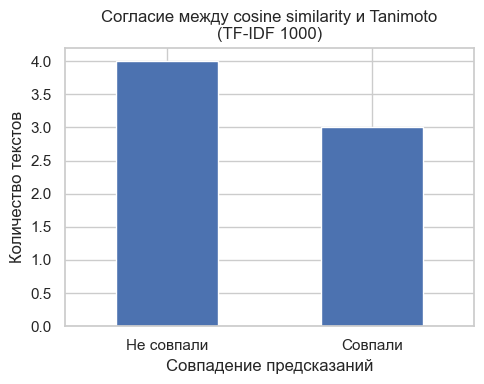

In [78]:
import matplotlib.pyplot as plt

agreement_counts = (
    df_combined['predicted_author_1000']
    == df_combined['predicted_author_tanimoto_1000']
).value_counts()

plt.figure(figsize=(5, 4))
agreement_counts.plot(kind='bar')

plt.title('Согласие между cosine similarity и Tanimoto\n(TF-IDF 1000)')
plt.ylabel('Количество текстов')
plt.xlabel('Совпадение предсказаний')
plt.xticks([0, 1], ['Не совпали', 'Совпали'], rotation=0)

plt.tight_layout()
plt.show()



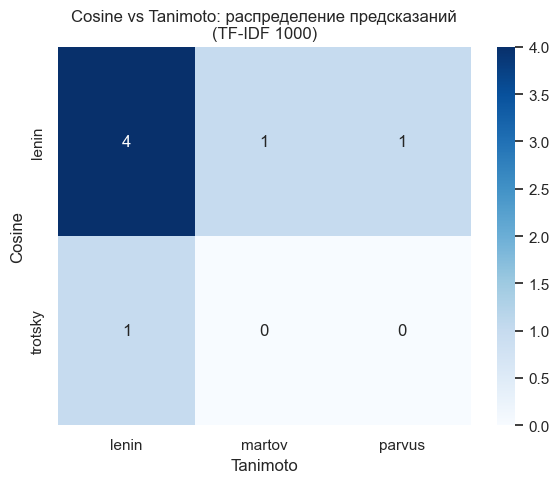

In [80]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

ct = pd.crosstab(
    df_combined['predicted_author_1000'],
    df_combined['predicted_author_tanimoto_1000']
)

plt.figure(figsize=(6, 5))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')

plt.title('Cosine vs Tanimoto: распределение предсказаний\n(TF-IDF 1000)')
plt.xlabel('Tanimoto')
plt.ylabel('Cosine')

plt.tight_layout()
plt.show()


In [ ]:
Краткая интерпретация 2 последних графиков:

Попытка визуализировать индивидуальные предсказания методов оказалась неинформативной из-за малого объёма корпуса. 
Анализ смещён в сторону представлений, позволяющих оценить согласие методов на уровне корпуса, а не отдельных текстов.
Корпус Ленина отличается большим размером, что во многом повлияло на результаты эксперимента.